In [ ]:
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sm

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from sklearn import datasets
from sklearn.metrics import mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
import pandas as pd

import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import tree
plt.style.use('seaborn-notebook')
import pylab

<ipython-input-1-cb0a2544f8b1>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [ ]:
df = pd.read_csv('NONROUNDED5YRML.csv', parse_dates = ["TimeStamp"])
df = df.sort_values('TimeStamp').set_index("TimeStamp")
#df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%m/%d/%Y %I:%M:%S %p')
df = df[df['Element'] == 'K119']
data = df.fillna(method='ffill')
data.drop(columns=['Element'], inplace=True)
data.drop(columns = ['Hourly Balance Piston Pressure'], inplace=True)

In [ ]:
data.head()

,Hourly Inboard Bearing Vibration,Hourly Outboard Bearing Vibration,Hourly Discharge Pressure,Hourly Flow Rate,Hourly Suction Pressure,Hourly Oil Injection Pressure,Hourly Gas Differential Pressure,Hourly Oil Boost Pressure,Hourly Slide Valve Position,Hourly Run Status Percentage
TimeStamp,,,,,,,,,,
2018-12-01 15:00:00,2.431878,3.001848,67.579582,8.602156,2.211478,109.602867,65.368347,42.026764,100.000000,98.333832
2018-12-01 16:00:00,2.484483,3.301203,67.005981,8.625750,2.007675,109.973724,64.998306,42.967743,99.797890,100.000000
2018-12-01 17:00:00,2.475523,3.461956,66.214813,8.638940,2.029016,109.610153,64.185799,43.395340,99.534210,100.000000
2018-12-01 18:00:00,2.514686,3.510100,66.179268,8.611704,1.980278,109.691978,64.198990,43.512711,99.760742,100.000000
2018-12-01 19:00:00,2.541709,3.678393,66.188126,8.626423,1.981163,109.951385,64.206963,43.763260,99.841507,100.000000


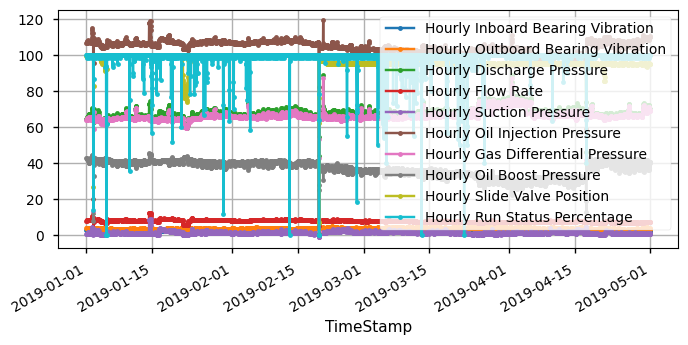

In [ ]:
data["2019-01":"2019-04"].plot(grid=True, marker = ".", figsize=(8, 3.5))
plt.show()

In [ ]:
response = data["Hourly Inboard Bearing Vibration"] / 1e6
predictors = data.drop("Hourly Inboard Bearing Vibration", axis = 1) / 1e6

# Reshape data

train_response = response["2018-12":"2023-05"]
valid_response = response["2023-06":]
train_predictors = predictors["2018-12":"2023-05"]
valid_predictors = predictors["2023-06":]



In [ ]:
def model_LSTM(train_predictors,train_response,dropout_prop=0.0,nb_units=10,batchsize=64,epoch=100,optimizer='adam'):
  regressor= Sequential()
  regressor.add(LSTM(units=nb_units, return_sequences = True , input_shape=(train_predictors.shape[1],1)))
  regressor.add(Dropout(dropout_prop))
  regressor.add(LSTM(units=nb_units, return_sequences = True ))
  regressor.add(Dropout(dropout_prop))
  regressor.add(LSTM(units=nb_units ))
  regressor.add(Dropout(dropout_prop))
  regressor.add(Dense(units=1))
  regressor.compile(optimizer= optimizer, loss= 'mean_squared_error')
  history=regressor.fit(train_predictors, train_response,validation_split=0.20, epochs=epoch, batch_size=batchsize)
  history.history
  return regressor

In [ ]:
def evaluate_error(model, valid_predictors, valid_response):
    predicted_vibration = model.predict(valid_predictors)

    # Flatten the predicted values if they are multi-dimensional
    predicted_vibration_flat = np.ravel(predicted_vibration)

    errors = abs(predicted_vibration_flat - valid_response)
    MAE = np.mean(errors)
    rmse = np.sqrt(mean_squared_error(valid_response, predicted_vibration_flat))

    return MAE, rmse, errors

In [ ]:
def train_model(train_predictors,train_response):


    model_regressor=model_LSTM(train_predictors,train_response,dropout_prop=0.0,nb_units=10,batchsize=16,epoch=50,optimizer='Adam')
    #rmse=evaluate_error(model=model_regressor,X_test=X_test,Y_test=Y_test)



    return model_regressor

In [ ]:
model = train_model(train_predictors,train_response)
#RMSE,MAE=evaluate_error(model,valid_predictors,valid_response)

Epoch 1/50
1971/1971 [==============================] - 40s 17ms/step - loss: 4.2118e-08 - val_loss: 1.5005e-11
Epoch 2/50
1971/1971 [==============================] - 33s 17ms/step - loss: 9.1366e-09 - val_loss: 8.5488e-10
Epoch 3/50
1971/1971 [==============================] - 31s 16ms/step - loss: 6.1153e-09 - val_loss: 4.3451e-10
Epoch 4/50
1971/1971 [==============================] - 32s 16ms/step - loss: 4.9348e-09 - val_loss: 6.0721e-12
Epoch 5/50
1971/1971 [==============================] - 31s 16ms/step - loss: 4.0222e-09 - val_loss: 1.0013e-09
Epoch 6/50
1971/1971 [==============================] - 31s 15ms/step - loss: 3.3326e-09 - val_loss: 1.2046e-10
Epoch 7/50
1971/1971 [==============================] - 33s 17ms/step - loss: 2.8142e-09 - val_loss: 1.1924e-09
Epoch 8/50
1971/1971 [==============================] - 31s 16ms/step - loss: 2.4344e-09 - val_loss: 2.1616e-09
Epoch 9/50
1971/1971 [==============================] - 31s 16ms/step - loss: 2.1848e-09 - val_loss: 2.6

In [ ]:
RMSE,MAE,errors=evaluate_error(model,valid_predictors,valid_response)
print('RMSE: ',RMSE,' MAE: ',MAE, 'Errors:', errors)

138/138 [==============================] - 3s 6ms/step
RMSE:  5.363805283501357e-06  MAE:  7.1338842932800275e-06 Errors: TimeStamp
2023-06-01 00:00:00    2.065750e-06
2023-06-01 01:00:00    2.007746e-06
2023-06-01 02:00:00    2.049520e-06
2023-06-01 03:00:00    1.468513e-06
2023-06-01 04:00:00    1.575833e-06
                           ...     
2023-11-30 20:00:00    3.099868e-07
2023-11-30 21:00:00    3.094356e-07
2023-11-30 22:00:00    3.557165e-07
2023-11-30 23:00:00    5.972574e-07
2023-12-01 00:00:00    3.731849e-07
Name: Hourly Inboard Bearing Vibration, Length: 4393, dtype: float64


In [ ]:
from scipy.optimize import minimize
import numpy as np

# Assuming train_predictors has shape (num_samples, num_features)

# Define the objective function to minimize
def objective_function(predictors, model, desired_response, fixed_indices, fixed_values):
    # Reshape predictors to match the input shape expected by your model
    predictors_reshaped = predictors.reshape((1, predictors.shape[0], 1))

    # Create a copy of predictors to avoid modifying the original array
    predictors_copy = predictors_reshaped.copy()

    # Replace the values of fixed predictors in the copy
    predictors_copy[:, fixed_indices, :] = fixed_values.reshape((1, len(fixed_indices), 1))

    # Predict the response using the model with the modified copy
    predicted_response = model.predict(predictors_copy)

    # Flatten the predicted values if they are multi-dimensional
    predicted_response_flat = np.ravel(predicted_response)

    # Calculate the difference between predicted and desired response
    error = predicted_response_flat - desired_response

    # Return the squared error as the objective to minimize
    return np.sum(error**2)

# Initial random input values
initial_predictors = np.random.rand(train_predictors.shape[1])

# Find the column indices of the predictors you want to fix
fixed_columns = ['Hourly Outboard Bearing Vibration', 'Hourly Flow Rate']
fixed_indices = [train_predictors.columns.get_loc(col) for col in fixed_columns]

# Values to fix for the specified predictors
fixed_values = train_predictors.iloc[0, fixed_indices].values  # Use the values from your data

# Define the optimization bounds if necessary
bounds = [(5, 100) for _ in range(train_predictors.shape[1])]

# Desired response value
desired_response = 8

# Perform optimization
result = minimize(objective_function, initial_predictors, args=(model, desired_response, fixed_indices, fixed_values), bounds=bounds)

# Extract the optimized input values
optimized_predictors = result.x

# Reshape the optimized predictors
optimized_predictors = optimized_predictors.reshape((1, optimized_predictors.shape[0], 1))

# Use the optimized predictors to get the predicted response
predicted_response = model.predict(optimized_predictors)

print("Optimized Predictors:", optimized_predictors)
print("Predicted Response:", predicted_response)


1/1 [==============================] - 0s 58ms/step
Optimized Predictors: [[[5.]
  [5.]
  [5.]
  [5.]
  [5.]
  [5.]
  [5.]
  [5.]
  [5.]]]
Predicted Response: [[1.1707573e-05]]


In [ ]:
from scipy.optimize import minimize

def objective_function(predictors):
    input_shape = (1, 9, 1)
    predictors1 = np.array(predictors)
    predictors_reshaped = predictors.reshape((1, predictors.shape[0], 1))
    predicted_response = model.predict(predictors_reshaped) * 1e6

    target_response = 8
    mse = np.mean((predicted_response - target_response) ** 2)

    return mse

# Flatten the 2D array train_predictors to a 1D array
initial_params = valid_predictors.values.ravel()

result = minimize(objective_function, initial_params, method='Powell', options={'tol': 1e-6})

optimal_params = result.x

print(optimal_params)

<ipython-input-14-756a6e0ffa11>:17: OptimizeWarning: Unknown solver options: tol
  result = minimize(objective_function, initial_params, method='Powell', options={'tol': 1e-6})


1/1 [==============================] - 5s 5s/step


In [ ]:
corr = data.corr()
corr["Hourly Inboard Bearing Vibration"].sort_values(ascending=False)

Hourly Inboard Bearing Vibration     1.000000
Hourly Outboard Bearing Vibration    0.961256
Hourly Oil Boost Pressure            0.667990
Hourly Run Status Percentage         0.527420
Hourly Oil Injection Pressure        0.499913
Hourly Flow Rate                     0.266722
Hourly Gas Differential Pressure     0.254211
Hourly Slide Valve Position          0.243711
Hourly Discharge Pressure            0.220320
Hourly Suction Pressure             -0.351615
Name: Hourly Inboard Bearing Vibration, dtype: float64